# Hubble Law Part 2: Roughly Calculating Extragalatic Distances
Author: Dylan Linthorne

## Objective: 
---

In this part of the lab we'll investigate how extragalactic distances can be estimated for spiral type galaxies. As mentioned in the introduction of part 1, distances are one of the hardest measurements in astronomy & astrophysics. We rely on objects with a consistent and known intrinsic brightness, what we refer to as Standard Candles, to properly survey the distances of these objects surroundings. This is a systematic study where our understanding of the distances of closer objects greatly impacts our measurements of further objects. Sometimes termed the distance ladder, astonomers use a systematic approach of using distances of closer objects to calibrate the methods of finding distances of further objects. Variable stars, like Cepheids, provide one of the first few rungs of the distance ladder, giving us a survey of distances within our galaxy and galactic local group. Whereas extragalactic distances are best estimated using the light output of type 1a supernovae. 

For majority of ourdistance measurements we will be using the average distances measured from (insert method and database). But some galaxies are missing distances. To fill in the gaps of data to extract a hubble constant, a rough estimate of the distance will be made using a calibrated image of the galaxy and knowing it's classification. To accomplish this task you'll gain the skills to process image data and it's metadata that is commonly used throughout astronomy. Specefically,

* Read and display images within a .Fits file.
* Read and extract metadata from the .Fits header.
* Transform pixel coordinates into celestial world coordinates.
* Calculate angular distances from user pixel input.

In [1]:
import pandas as pd            #for our data structuress
import numpy as np             #for manipulating data
import matplotlib.pyplot as plt       #for visualization

### Reading .Fits Image File:


All working and amateur astronomers will have worked with some kind of image file. The image file being an array of pixels with each pixel carrying either a single value (grayscale) or multiple (RGB). Having only the pixel values isn't enough for astronomers to make sense of the data. These pixels represent stars, galaxies, atmospheres, etc, with their own coordinate systems, backgrounds, contaminations, and the location where the observation took place. Which is why most working astronomers use the FITS file formate. A FITS file contains not only pixel information but includes metadata, which may describe the observers coordinates (latitude, longitude), time of observation, exposure, celestial coordinates, and more. The metadata can be anything the observer deems relevant for future analysis of the image. 

In [2]:
#!pip install astropy
from astropy.io import fits

In [3]:
with fits.open('NGCData/Fits/6217.fits') as hdul:
    hdul.info()
    image_data = hdul[0].data
    image_header = hdul[0].header
image_header

Filename: NGCData/Fits/6217.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   (285, 285)   float32   


SIMPLE  =                    T / Written by IDL:  Fri Jul 11 12:34:26 2008      
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                  285 /Number of positions along axis 1                
NAXIS2  =                  285 /Number of positions along axis 2                
DATE    = '2008-07-11'         / Creation UTC (CCCC-MM-DD) date of FITS header  
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
BUNIT   = 'KM/S    '           /                                                
BSCALE  =              1.00000 /                                                
BZERO   =              0.00000 /                                                
CTYPE1  = 'RA---ARC'           /X-axis type                                     
CTYPE2  = 'DEC--ARC'        

For the this lab, we'll only be concerned with measuring the angular size of the object. Keeping our interest in only the information that'll help up accomplish this task. Each pixel is oriented in the vertical and horizontal direction, but this does not correspond to the celestrial coordinates of the sky, right accension (RA) and declination (DEC). If we inspect the contents the header above, it's easy to see variables that pertain to (RA, DEC) = $(\alpha , \delta)$

Programs such as AstroIMJ, IRAF and MAXIMDL use the positional informational above to transfrom each pixel to the proper celestial coordinates $(\alpha,\delta)$. We simply rotate the pixel coordinate system into the celestial coordinate system through an angle CROTA2 about reference pixel point (CRPIX1,CRPIX2) with a known RA and DEC, $(\alpha_0,\delta_0)$ =  (CRVAL1,CRVAL2),

$$ \alpha = s_{1}\sum_{j=(\alpha,\delta)}^N m_{1,j}(p_j - r_j)\;  + \alpha_{0},   \;\;\;\;\;\;\;\;\;\;\; \delta = s_{2}\sum_{j=(\alpha,\delta)}^N m_{2,j}(p_j - r_j) + \delta_{0} $$

Where $m_{i,j}$ is the rotation matrix from the pixels $(i,j)$ to $(\alpha,\delta)$. $s_i$ = CDELTi is the scale factor in [degree/pixel], $p_i$ are the $i^{th}$ pixel number, $r_{i}$ = CRPIXi the reference pixel positions, and $N$ = NAXIS the number of axes. Create variables and initalize them with the header data you extracted above.

In [24]:
NAXIS = 2;                            # Number of axes
NAXIS1 = 285;                         # Number of points/pixels in first axis
NAXIS2 = 285;                         # Number of points/pixels in second axis

CRVAL1 = 248.1549;                    # Reference pixel RA
CRVAL2 = 78.2013;                     # Reference pixel Dec
CRPIX1 = 138;                         # Refernece pixel first axis position 
CRPIX2 = 167;                         # Refernece pixel first axis position

CROTA2 = np.radians(358.2200);           # Convert rotation angle from rads to degree
CDELT1 = -1.8996e-04;                 # First axis pixel to degree conversion
CDELT2 = 1.8996e-04;                  # Second axis pixel to degree conversion

### Viewing the Raw Image 
Next would be to view the image of the galaxy. There are two methods of ploting an image away. 1) using matplotplib to plot the grid values of the array into a 2D plot. Deep field images taken by your telescopes CCD can be noisy and the constrast used to display the image may leave out some information to the veiwer. Modern astronomical Fits readers like AstroIMJ cut out some of the darks and highlights to optimally veiw the objects in the image. To bypass image histogram minipulation we'll plot the image as Contour plot with high number of contours. This way we the plot we'll capture the essence of the low luminosity of the galactic spiral arms.

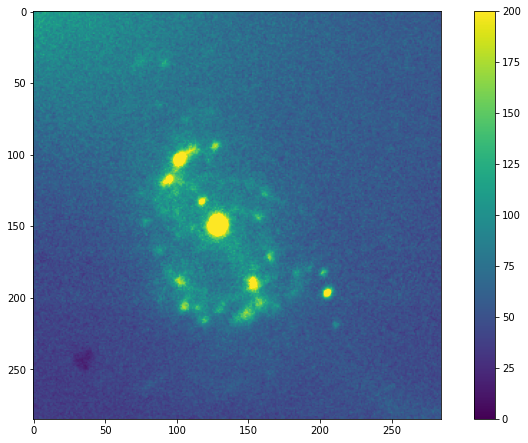

In [121]:
plt.figure(figsize=(12, 7.5))
plt.imshow(image_data, vmin=0, vmax=200);
plt.colorbar();

### Conversion to Celestial World Coordinates:


Converting the pixel coordinate system into the celestial world coordinate system involves using the above equations on each pixel. A better way of thinking of this transformation is that for each pixel we will assign an RA and DEC ontop of it's intensity value, $(I_{i}, \alpha_i, \delta_i )$. The first ingredient is to construct the rotation matrix using the anlge of rotation CROTA2. 
$$ R(\theta) = \begin{pmatrix}
\text{cos}(\theta) & -\text{sin}(\theta) \\
\text{sin}(\theta) & \text{cos}(\theta)
\end{pmatrix}$$

In [66]:
rotate = np.array([[np.cos(CROTA2), -np.sin(CROTA2)],[np.sin(CROTA2), np.cos(CROTA2)]]);

Below is the loop that'll will iterate through each pixel $(i,j)$ and calculate its $(\alpha,\delta)$ using the header data and the rotation matrix. The array before the loop will be filled with the calculated values. It'll be sliced into three two dimensional arrays one for each; intensity, Ra, and DEC. Your look should include:
* shifted pixels with respected to the reference pixel CRPIX1(2)
* scaled pixels using calibration values CDELT1(2)
* construct a vector of pixel coordinates
* rotate this pixel vector
* finally shift the rotated values by the reference RA, DEC using CRVAL1(2)

In [92]:
full = np.zeros((NAXIS1,NAXIS2,3));

for i in range(NAXIS1):
    for j in range(NAXIS2):
        
        iprime = i - CRPIX1;     # shift pixels to relative coords    
        jprime = j - CRPIX2;
        
        iscaled = iprime * CDELT1;    # scale by conversion factor
        jscaled = jprime * CDELT2;
        
        pixel = np.array([[iscaled, jscaled]]).T;   # create vector of pixels
        transform = np.dot(rotate,pixel);   # rotate the vector into new frame
        
        full[i,j,0] = (transform[0] + CRVAL1);   # calibrate to know RA
        full[i,j,1] = (transform[1] + CRVAL2);   # calibrate to know DEC
        full[i,j,2] = image_data[i,j]

In [94]:
ra = full[:,:,0]; 
dec = full[:,:,1];
intensity = full[:,:,2];

Visualize the new coordinate system by overlaying it ontop of the original image. The easiest way would be to plot the contour plots of both variables. Reason being, each slice of the countor would correspond to a single RA (DEC) value, giving us a new coordinate grid. 

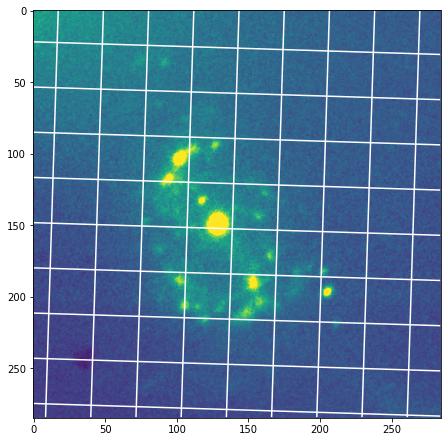

In [108]:
plt.figure(figsize=(12, 7.5))
plt.imshow(image_data, vmin=0, vmax=200);
plt.contour(ra, 10, colors ="white")
plt.contour(dec, 10,  colors ="white")


### Finding Angular Size and Extragalactic Distance:

The key assumption for this lab is that we are measuring galaxies of similar Hubble type (spiral sb galaxies). We then assume that they are all the same physical size, no matter where they are. This is known as "the standard ruler" assumption in cosmology [cite]. Under this assumption, we can use basic geometry to approximate the distance by relating it's angular size to it's diameter. This relation is $D \approx S/\theta$ and shown in the following diagram,

<center> <img src="Figs/angular-01.png" width="740" height="240" > </center>

Where $D$ is the distance between the observer and the galaxy in Mpc, $\theta$ the angular size in radians, and $S$ is the galactic diameter. The variable which we have to estimate is  using the standard ruler of spiral galaxies. The standard ruler we'll use for S(b) galaxies is $S = .020$ Mpc. Use the the image you plotted to find the pixel values of the edge of the semi-major axis of the galaxy. You can do this by just hovering your mouse over the point or by visual inspection. 

#### Quote the difference in DEC of each end point (in rads):


In [110]:
distance_DEC = (dec[50,50]-dec[220,220])*(np.pi/180)

#### Quote the difference in RA of each end point (in rads):


In [111]:
distance_RA = (ra[50,50]-ra[220,220])*(np.pi/180)

#### Calculate and qoute the total angular distance (square root of the sum of squares):


In [112]:
angular_arc = np.sqrt(distance_DEC**2 + distance_RA**2)

#### Lastly, use simple geometry to calculate the distance (in Mpc):


In [119]:
distance = .020/angular_arc

In [120]:
print("Angular distance of to galaxy: " + str(angular_arc))
print("Distance to galaxy in Mpc: " + str(distance))

Angular distance of to galaxy: 0.000797082818325042
Distance to galaxy in Mpc: 25.091495563820082
